In [1]:
import tensorflow as tf
import numpy as np

# Use to generate new data by manipulation

## What is this?
VAE stands for Variational Auto Encoder. Which means that is trained to reproduce or reconstruct from a latent space the input. Is an strategy to learn that latent space

It has 2 important blocks the Encoder wich will be responsable for condensing the data into a low dimensional latent space or just a vector.
And the Decoder by taking one point(how do you choose a point? By sampling) from the latent space is able to reconstruct a new image.

## How do VAEs build a latent space?
That is what difference a VAE from a AE that the V which means variational and allows the VAE to create continuous and structured latent spaces.

## How do you sample the latent space?


The latent space is structured, non sparse continuous and low dimentional where each direction encode a meanful axis of variation(V) of the data. And that means it can be manipulated with content vectors. Vectors that are isolated and represent a concept.
Like the concept of smile another image representation can be added to the smile concept vector then passed to the decoder to create a new image with the person smiling.

```There are concept vectors for any independent direction of the latent space```
```deeplearning with bayesian inference```

## Steps
- Build the encoder
    - The output will be 2 vectors mean and variance
- Build the sampler using a random small vector along with the 2 vectors the encoder will give us
    - normal dist value = mean * exp(std) * epsilon / epsilon is a random small vector from the latent space
- Build the loss
    - kubell-divergence
    - reconstruction loss mean already coded in keras
- Build the decoder
    - the decoder will take the sampled input and reconstruct it to a valid image!

# Encoder

The encoder will transform the image into 2 parameters vectors that will be used to form a normal distribution, mean_vector and standard_deviation_vector

Dummy dataset Nmist

In [2]:
(X_train, _), (X_test, _) = tf.keras.datasets.mnist.load_data()

mnist_digits = np.concatenate([X_train, X_test])
mnist_digits = mnist_digits[:, :, :, np.newaxis]/255.

In [3]:
mnist_digits.shape

(70000, 28, 28, 1)

In [4]:
LATENT_DIMS = 2
IMAGE_CHANNELS = 1
PROY_DIM = 16

In [5]:
# I need to use a fix size.. This should not be a limitation in the future.
# If I create a class I can surpass that limitation
X_input_encoder = tf.keras.Input(shape=(28, 28, IMAGE_CHANNELS))

# add more convs
X = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", strides=2, padding="same")(X_input_encoder)
X = tf.keras.layers.Flatten()(X)

# Try a proyection model sequence latter
X = tf.keras.layers.Dense(units=PROY_DIM, activation="relu")(X)
# X = tf.keras.Sequential([tf.keras.layers.Dense(units=PROY_DIM, activation="relu"), tf.keras.layers.Dense(units=PROY_DIM)])(X)

z_mean = tf.keras.layers.Dense(units=LATENT_DIMS, name="z_mean")(X)
z_log_var = tf.keras.layers.Dense(units=LATENT_DIMS, name="z_log_var")(X)

encoder = tf.keras.Model(inputs=X_input_encoder, outputs=[z_mean, z_log_var])

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



In [6]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 64)   640         ['input_1[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 12544)        0           ['conv2d[0][0]']                 
                                                                                                  
 dense (Dense)                  (None, 16)           200720      ['flatten[0][0]']                
                                                                                              

# Sampler!

We are sampling from a normal distribution

normal = mu + exp(sigma) * epsilon

epsilon is a random number from a normal distribution

In [7]:
class Sampler(tf.keras.layers.Layer):
    def call(self, z_mean, z_sigma):
        # get the batch size
        batch_size = tf.shape(z_mean)[0]
        latent_dim = tf.shape(z_mean)[1]

        #Epsilon should be the same size as our vectors
        # here we are in the training and everything gets processed in batch
        epsilon = tf.random.normal(shape=(batch_size, latent_dim))

        #This returns a sample point from the distribution we are trying to find.
        # A normal distribution
        # Why over 2? is that 2 the N elements?
        return z_mean + tf.math.exp(z_sigma/2) * epsilon

# Decoder

In [8]:
# the input is the output of the sample(encoder(image))
IMAGE_HEIGHT = IMAGE_WIDTH = 7
IMAGE_CHANNELS = 1
CHANNELS_ENCODER_OUTPUT = 64

X_input_decoder = tf.keras.Input(shape=(LATENT_DIMS,))

X = tf.keras.layers.Dense(units=IMAGE_HEIGHT * IMAGE_WIDTH * CHANNELS_ENCODER_OUTPUT)(X_input_decoder)
X = tf.keras.layers.Reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS_ENCODER_OUTPUT))(X)

X = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(X)
X = tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(X)

X_decoder_output = tf.keras.layers.Conv2D(IMAGE_CHANNELS, 3, activation="sigmoid", padding="same")(X)

#X_input_decoder latent input
decoder = tf.keras.Model(X_input_decoder, X_decoder_output, name="decoder")

In [9]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 3136)              404544    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 1)         289 

In [10]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, sampler, **kwars):
        """ 
         It has 3 main blocks 
            - encoder
            - decoder
            - sampler
        """
        super().__init__(**kwars)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = sampler

        # sum all losses
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_flat_loss")

        # how close the reconstructed sample by the decoder is to the original source
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")

        # divergence from the distribution created to model the latent space and the real one which is a normal distribution
        # From where the epsilon point comes from?
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        z_mean, z_sigma = self.encoder(inputs)
        return self.decoder(self.sampler(z_mean, z_sigma))

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]
    
    def train_step(self, batch_data):
        with tf.GradientTape() as tape:
            z_mean, z_sigma = self.encoder(batch_data)
            sampled_point_z = self.sampler(z_mean, z_sigma)
            reconstructed_input = self.decoder(sampled_point_z)

            reconstruction_loss = tf.reduce_mean(
                # The image needs to be normalized between 0 and 1 for this to make sense
                tf.reduce_sum(tf.keras.losses.binary_crossentropy(batch_data, reconstructed_input),
                              # Sum up each point in the batch
                              axis=(1, 2))
            )

            kl_loss = -0.5 * (1 + z_sigma - tf.math.square(z_mean) - tf.math.exp(z_sigma))

            # this adds all 2 losses into one
            # how well the input was reconstructed and the distribution difference to create the latent space
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)

        # Standard way to propagate the error signal?
        gradients = tape.gradient(total_loss, self.trainable_weights)
        # gradients = tape.gradient(total_loss, [z_mean, z_sigma])
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        # self.optimizer.apply_gradients(zip(gradients, [z_mean, z_sigma]))

        # add and average the loss so far up to this batch
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }


In [11]:
tf.keras.backend.clear_session()

In [12]:
vae = VAE(encoder=encoder, decoder=decoder, sampler=Sampler())

In [13]:
vae.compile(optimizer=tf.keras.optimizers.legacy.Adam(), run_eagerly=None)
# vae.compile(optimizer=tf.keras.optimizers.legacy.Adam(), run_eagerly=True)

In [14]:
vae.fit(mnist_digits, epochs=5, batch_size=128)

Epoch 1/5


2023-05-19 08:57:59.444708: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


547/547 [==============================] - 11s 18ms/step - total_loss: 213.5930 - reconstruction_loss: 159.6158 - kl_loss: 1.1210
Epoch 2/5
547/547 [==============================] - 9s 17ms/step - total_loss: 120.3492 - reconstruction_loss: 116.5790 - kl_loss: 1.3939
Epoch 3/5
547/547 [==============================] - 9s 17ms/step - total_loss: 113.2439 - reconstruction_loss: 111.0034 - kl_loss: 1.4222
Epoch 4/5
547/547 [==============================] - 9s 17ms/step - total_loss: 110.5556 - reconstruction_loss: 108.4719 - kl_loss: 1.3990
Epoch 5/5
547/547 [==============================] - 9s 17ms/step - total_loss: 108.7414 - reconstruction_loss: 106.9106 - kl_loss: 1.3754


In [15]:
sample = mnist_digits[0]
sample = np.expand_dims(sample, axis=0)

In [16]:
reconstructed = vae.predict(sample)

1/1 [==============================] - 0s 155ms/step


In [17]:
import matplotlib.pyplot as plt

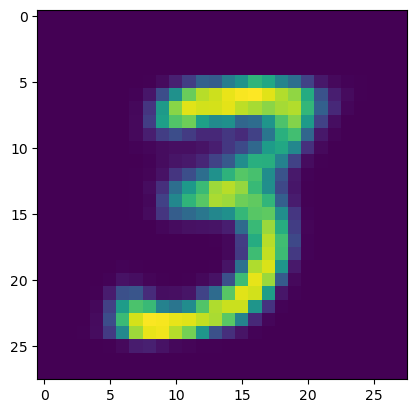

In [18]:
reconstructed[0] *= 255
reconstructed[0] = reconstructed[0].astype("uint8")
plt.imshow(reconstructed[0])

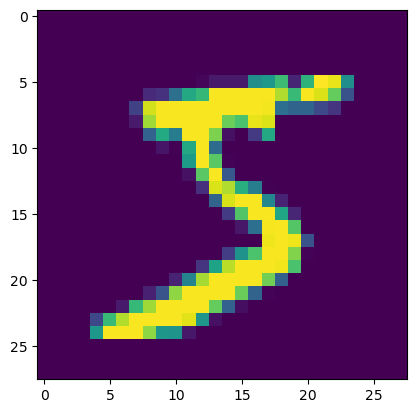

In [19]:
plt.imshow(sample[0])

In [20]:
m, s = encoder(sample)

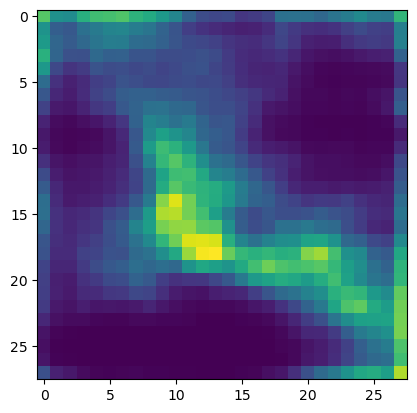

In [21]:
plt.imshow(decoder(
                    tf.random.uniform(shape=(1,LATENT_DIMS)),
                    tf.random.uniform(shape=(1,LATENT_DIMS)))[0]
)